# Project: Building a Spam Filter with Naive Bayes from scratch

## Introduction:

In this project we're going to build a spam filter for SMS messages.To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

The dataset was put together by `Tiago A. Almeida` and `José María Gómez Hidalgo`, and it can be downloaded from [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The data collection process is described in more details on [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition).

Our end goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

Let's start by reading in the dataset. 

## Data exploration

In [1]:
import pandas as pd
data = pd.read_csv('SMSSpamCollection',sep='\t',header=None,names=['Label','SMS'])
data.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Label    5572 non-null object
SMS      5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [3]:
data.Label.value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

* About 87% of the messages are ham ("ham" means non-spam), and the remaining 13% are spam.

##  Training and Test Set

To test the spam filter, we're first going to split our dataset into two categories:

* A training set, which we'll use to "train" the computer how to classify messages.
* A test set, which we'll use to test how good the spam filter is with classifying new messages.

We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

The training set will have 4,458 messages (about 80% of the dataset).
The test set will have 1,114 messages (about 20% of the dataset) we're going to treat these messages as new and have the filter classify them. Once we have the results, we'll be able to compare the algorithm classification with that done by a human, and this way we'll see how good the spam filter really is.

 We're going to start by randomizing the entire dataset to ensure that spam and ham messages are spread properly throughout the dataset.

In [4]:
# randomizing the data set
data = data.sample(frac=1,random_state=1)
data.head()

,Label,SMS
1078,ham,"Yep, by the pretty sculpture"
4028,ham,"Yes, princess. Are you going to make me moan?"
958,ham,Welp apparently he retired
4642,ham,Havent.
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [5]:
# keeping 80% of the data set for training
training_set = data.iloc[:round(data.shape[0]*0.8),:].reset_index(drop=True)
# keeping 20% of the data set for training
test_set = data.iloc[round(data.shape[0]*0.8):,:].reset_index(drop=True)

In [6]:
print(training_set.head())
training_set.Label.value_counts(normalize=True)*100

  Label                                                SMS
0   ham                       Yep, by the pretty sculpture
1   ham      Yes, princess. Are you going to make me moan?
2   ham                         Welp apparently he retired
3   ham                                            Havent.
4   ham  I forgot 2 ask ü all smth.. There's a card on ...


ham     86.54105
spam    13.45895
Name: Label, dtype: float64

In [7]:
print(test_set.head())
test_set.Label.value_counts(normalize=True)*100

  Label                                                SMS
0   ham          Later i guess. I needa do mcat study too.
1   ham             But i haf enuff space got like 4 mb...
2  spam  Had your mobile 10 mths? Update to latest Oran...
3   ham  All sounds good. Fingers . Makes it difficult ...
4   ham  All done, all handed in. Don't know if mega sh...


ham     86.804309
spam    13.195691
Name: Label, dtype: float64

 * The percentages of spam SMS and non-spam SMS are similar to what we have in the full dataset, so we can confirm that the training set and the test set are reprenstatives.

## Data cleaning

To make the calculations easier, we want bring the data to this format :

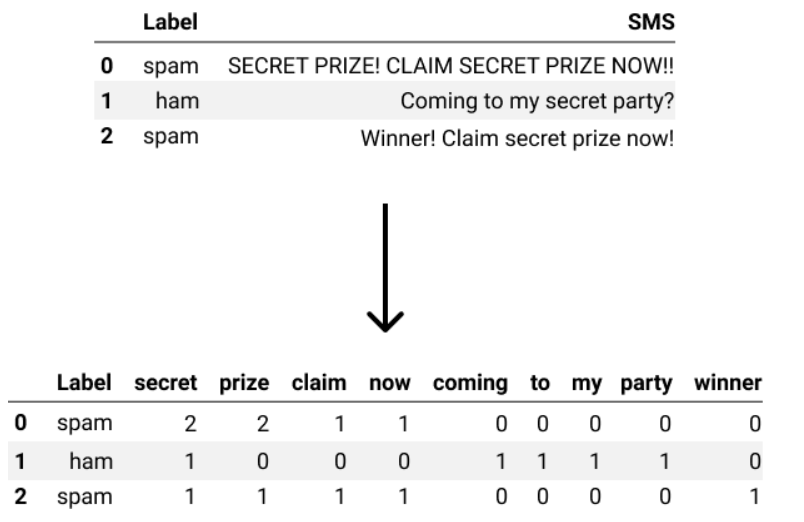


The SMS column doesn't exist anymore.
Instead, the SMS column is replaced by a series of new columns, where each column represents a unique word from the vocabulary.
Each row describes a single message. 
All words in the vocabulary are in lower case, so "SECRET" and "secret" come to be considered to be the same word.
       Punctuation is not taken into account anymore.

In [8]:
# removing punctuation
training_set.SMS = training_set.SMS.str.replace('\W',' ').str.lower()
training_set.SMS.head()

0                         yep  by the pretty sculpture
1        yes  princess  are you going to make me moan 
2                           welp apparently he retired
3                                              havent 
4    i forgot 2 ask ü all smth   there s a card on ...
Name: SMS, dtype: object

In [9]:
# creating the vocabulary, which in this context means a list with all the unique words in our training set.
training_set.SMS = training_set.SMS.str.split() 
# joining all the lists
vocabulary = training_set.SMS.sum()
# keeping unique words using list then change the type of vocabulary to list
vocabulary = list(set(vocabulary))
print(len(vocabulary))
print(vocabulary[:10])

7783
['want2come', 'restock', 'three', 'dependents', 'html', '08719181503', 'get', 'atlast', 'spk', 'mush']


* Vocabulary contains 7783 of unique words.

We're now going to use the vocabulary we just created to make the data transformation we want.

In [10]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index]+=1     

In [11]:
# converting word_counts_per_sms to a dataframe
word_counts_per_sms = pd.DataFrame(word_counts_per_sms)
word_counts_per_sms.head()

,want2come,restock,three,dependents,html,08719181503,get,atlast,spk,mush,...,lil,kinda,impression,emergency,08712317606,himself,opener,dsn,contribute,tech
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# joining the two dataframes  training_set and word_counts_per_sms side by side
training_set = pd.concat([training_set,word_counts_per_sms],axis=1)
print(training_set.shape)
training_set.head()

(4458, 7785)


,Label,SMS,want2come,restock,three,dependents,html,08719181503,get,atlast,...,lil,kinda,impression,emergency,08712317606,himself,opener,dsn,contribute,tech
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we're done with data cleaning and have a training set to work with, we can begin creating the spam filter. The Naive Bayes algorithm will need to answer these two probability questions to be able to classify new messages:
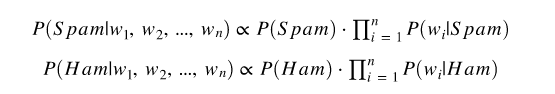
Also, to calculate P(wi|Spam) and P(wi|Ham) inside the formulas above, we'll need to use these equations:
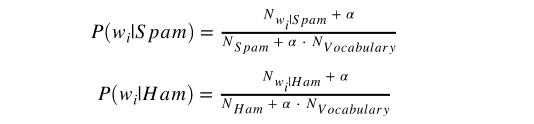

Some of the terms in the four equations above will have the same value for every new message. As a start, let's first calculate:

* P(Spam) and P(Ham)
* NSpam, NHam, NVocabulary

Where:

   * NSpam is equal to the number of words in all the spam messages — it's not equal to the number of spam messages, and it's not equal to the total number of unique words in spam messages.
   * NHam is equal to the number of words in all the non-spam messages — it's not equal to the number of non-spam messages, and it's not equal to the total number of unique words in non-spam messages.

We'll also use Laplace smoothing and set 
α
=
1


## Setting the classifier constants

In [13]:
# calculating P(Spam) and P(Ham):
p_ham = training_set.Label.value_counts(normalize=True)['ham']
p_spam = training_set.Label.value_counts(normalize=True)['spam']
print('p_ham = {}\np_spam = {}'.format(p_ham,p_spam))

p_ham = 0.8654104979811574
p_spam = 0.13458950201884254


In [14]:
# calculating number of words in spam SMS n_spam  and number of words in non-spam SMS n_ham:
words = word_counts_per_sms.columns
n_spam = training_set.loc[training_set.Label=='spam',words].values.sum()
n_ham= training_set.loc[training_set.Label=='ham',words].values.sum()
print('n_spam = {}\nn_ham= {}'.format(n_spam,n_ham))

n_spam = 15190
n_ham= 57237


In [15]:
alpha = 1
n_vocabulary = len(vocabulary)
print('alpha = {}\nn_vocabulary= {}'.format(alpha,n_vocabulary))

alpha = 1
n_vocabulary= 7783


## Setting the classifier parameters

Now, for each word in our vocabulary, we have to calculate both P(wi|Spam) and P(wi|Ham) which are the parameters of the Naive bayes classifier.

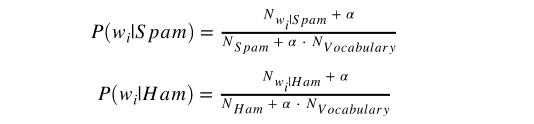

In [16]:
# seperating spam and ham SMS from the training set
spam_training_set = training_set[training_set.Label=='spam']
ham_training_set = training_set[training_set.Label=='ham']

In [17]:
# initiating parameters
spam_parameter = {word:0 for word in word_counts_per_sms}
ham_parameter = {word:0 for word in word_counts_per_sms}

In [18]:
# calculating parameters
for word in vocabulary:
    
    p_word_given_spam = spam_training_set[word].sum()
    spam_parameter[word] = (p_word_given_spam + alpha) / (n_spam + alpha * n_vocabulary)

    p_word_given_ham = ham_training_set[word].sum()
    ham_parameter[word] = (p_word_given_ham + alpha) / (n_ham + alpha * n_vocabulary)

## Spam filter classifier

Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. The spam filter can be understood as a function that:

* Takes in as input a new message (w1, w2, ..., wn)
* Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)
* Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:

  * If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
  * If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
  * If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

In [19]:
import re

def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()



    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message :
        if word in spam_parameter:
            p_spam_given_message *= spam_parameter[word]
        if word in ham_parameter:
            p_ham_given_message *= ham_parameter[word]
        
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [20]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [21]:
classify('Sounds good, Tom, then see u there')

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


## Measuring classifier accuracy

We'll now try to determine how well the spam filter does on our test set of 1,114 messages.
we'll change the classify() function that we wrote previously to return the labels instead of printing them.

In [22]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message :
        if word in spam_parameter:
            p_spam_given_message *= spam_parameter[word]
            
        if word in ham_parameter:
            p_ham_given_message *= ham_parameter[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'

Now that we have a function that returns labels instead of printing them, we can use it to create a new column in our test set.

In [23]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Now we can compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages. To make the measurement, we'll use accuracy as a metric:

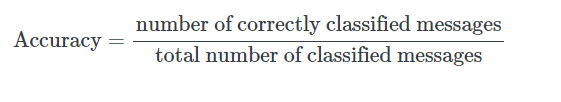

In [24]:
correct = 0
total = test_set.shape[0]
for index, row in test_set.iterrows():
    if row['Label']==row['predicted']:
        correct+=1
        
accuracy = correct / total
print('total =',total)
print('correct =',correct)
print('incorrect =',total - correct)
print('accuracy =',accuracy)

total = 1114
correct = 1100
incorrect = 14
accuracy = 0.9874326750448833


 ## Conclusion
 
 The accuracy is about 98.74 %, which is really good. Our spam filter looked at 1,114 messages that it hasn't seen in training, and classified 14 incorrectly.